In [2]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.3'

os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()



Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.co

In [3]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-09-03 19:17:15--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  --.-KB/s    in 0.08s   

2022-09-03 19:17:16 (10.3 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName("kitchen_ETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [6]:
# Import Amazon Data
from pyspark import SparkFiles
url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_Improvement_v1_00.tsv.gz'
spark.sparkContext.addFile(url)

In [7]:
homeimp_df = spark.read.csv(SparkFiles.get('amazon_reviews_us_Home_Improvement_v1_00.tsv.gz'), sep='\t', header=True)
homeimp_df = homeimp_df.dropDuplicates(['review_id'])

In [8]:
homeimp_df.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   48881148|R215C9BDXTDQOW|B00FR4YQYK|     381800308|SadoTech Model C ...|Home Improvement|          4|            0|          0|   N|                Y|          Four Stars|        good product| 2015-08-31|
|         US|   47882936|R1DTPUV1J57YHA|B00439MYYE|     921341748|iSpring T32M 3.2 ...|Home Improvement|          5|    

In [9]:
# Count the number of records (rows) in the dataset.
homeimp_df.count()

2634781

### Function to set nullable states to match schema

In [10]:
import pyspark.sql.functions as F

# https://stackoverflow.com/questions/46072411/can-i-change-the-nullability-of-a-column-in-my-spark-dataframe



def set_df_columns_nullable(spark, df, column_list, nullable=True):
    for struct_field in df.schema:
        if struct_field.name in column_list:
            struct_field.nullable = nullable
    df_mod = spark.createDataFrame(df.rdd, df.schema)
    return df_mod

In [11]:
# Transform the dataset to fit the tables in the schema file. Be sure the DataFrames match in data type and in column name.

# Schema: 
# CREATE TABLE review_id_table (
#   review_id TEXT PRIMARY KEY NOT NULL,
#   customer_id INTEGER,
#   product_id TEXT,
#   product_parent INTEGER,
#   review_date DATE -- this should be in the formate yyyy-mm-dd
# );



In [12]:
# Check datatypes
homeimp_df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [13]:
# Convert columns in root dataframe to schema datatype
from pyspark.sql.types import IntegerType,DateType
homeimp_df = homeimp_df.withColumn('customer_id', homeimp_df['customer_id'].cast(IntegerType()))
homeimp_df = homeimp_df.withColumn('product_parent', homeimp_df['product_parent'].cast(IntegerType()))
homeimp_df = homeimp_df.withColumn('review_date', homeimp_df['review_date'].cast(DateType()))

# vine
homeimp_df = homeimp_df.withColumn('star_rating', homeimp_df.star_rating.cast(IntegerType()))
homeimp_df = homeimp_df.withColumn('helpful_votes', homeimp_df.helpful_votes.cast(IntegerType()))
homeimp_df = homeimp_df.withColumn('total_votes', homeimp_df.total_votes.cast(IntegerType()))

In [14]:
homeimp_df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)



### review_id_table table

In [15]:
homeimp_review_id_df = homeimp_df.select(['review_id','customer_id','product_id','product_parent','review_date']).dropna()
homeimp_review_id_df.show(2)

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
|R215C9BDXTDQOW|   48881148|B00FR4YQYK|     381800308| 2015-08-31|
|R1DTPUV1J57YHA|   47882936|B00439MYYE|     921341748| 2015-08-31|
+--------------+-----------+----------+--------------+-----------+
only showing top 2 rows



In [16]:
# fix nullability
homeimp_review_id_df = set_df_columns_nullable(spark,homeimp_review_id_df,['review_id'], False)

homeimp_review_id_df.printSchema()

root
 |-- review_id: string (nullable = false)
 |-- customer_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- review_date: date (nullable = true)



### products table

In [17]:
homeimp_products_df = homeimp_df.select(['product_id','product_title']).dropna()
homeimp_products_df.show(2)

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B00FR4YQYK|SadoTech Model C ...|
|B00439MYYE|iSpring T32M 3.2 ...|
+----------+--------------------+
only showing top 2 rows



In [18]:
# fix nullability
homeimp_products_df = set_df_columns_nullable(spark,homeimp_products_df,['product_id'], False)

homeimp_products_df.printSchema()

root
 |-- product_id: string (nullable = false)
 |-- product_title: string (nullable = true)



### customers table

In [19]:
homeimp_customers_df = homeimp_df.select(['customer_id'])

In [20]:
homeimp_customers_df = homeimp_df.groupBy('customer_id').count()
homeimp_customers_df.show(5)

+-----------+-----+
|customer_id|count|
+-----------+-----+
|   28377689|    1|
|   28258386|    2|
|    9967574|    1|
|   25153155|    1|
|   10088068|    1|
+-----------+-----+
only showing top 5 rows



In [21]:
homeimp_customers_df = homeimp_customers_df.withColumnRenamed('count','customer_count')
homeimp_customers_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   28377689|             1|
|   28258386|             2|
|    9967574|             1|
|   25153155|             1|
|   10088068|             1|
+-----------+--------------+
only showing top 5 rows



In [22]:
# fix nullability
homeimp_customers_df = set_df_columns_nullable(spark,homeimp_customers_df,['customer_id'], False)
homeimp_customers_df = set_df_columns_nullable(spark,homeimp_customers_df,['customer_count'], True)

homeimp_customers_df.printSchema()

root
 |-- customer_id: integer (nullable = false)
 |-- customer_count: long (nullable = true)



### vine table

In [23]:
homeimp_vine_df = homeimp_df.select(['review_id','star_rating','helpful_votes','total_votes','vine'])
homeimp_vine_df.show(5)

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
|R215C9BDXTDQOW|          4|            0|          0|   N|
|R1DTPUV1J57YHA|          5|            0|          0|   N|
| RFAZK5EWKJWOU|          5|            0|          0|   N|
|R2XT8X0O0WS1AL|          5|            0|          0|   N|
|R14GRNANKO2Y2J|          5|            0|          0|   N|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows



In [24]:
# fix nullability
homeimp_vine_df = set_df_columns_nullable(spark, homeimp_vine_df, ['review_id'], False)

homeimp_vine_df.printSchema()

root
 |-- review_id: string (nullable = false)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)



In [25]:
# Load the DataFrames that correspond to tables into an RDS instance. 
# Note: This process can take up to 10 minutes for each. Be sure that everything is correct before uploading.
# from config import aws_url, aws_pw


# aws_url = 'http'
# aws_pw = 'pw'

# mode = "append"
# jdbc_url=f"jdbc:postgresql://{aws_url}:5432/postgres"
# config = {"user":"postgres", 
#           "password": aws_pw, 
#           "driver":"org.postgresql.Driver"}

In [26]:
# df_list =    [kitchen_review_id_df, kitchen_products_df, kitchen_customers_df, kitchen_vine_df]
# rds_tables = ['review_id_table',    'products',           'customers',         'vine_table']

# for i in range(len(df_list)):
#   df_list[i].write.jdbc(url=jdbc_url, table=rds_tables[i], mode=mode, properties=config)

# Level-2

In [27]:
vine_yes_df = homeimp_vine_df.filter(homeimp_vine_df['vine'] == 'Y')
vine_yes_df.show(5)

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
|R3OPBTY9W51JZA|          4|            0|          0|   Y|
|R35ZWBL9SCZ5B9|          4|            0|          0|   Y|
|R22Q1O3UQ2CODT|          5|            0|          0|   Y|
|R13CEN8DF0BCCO|          3|            0|          0|   Y|
|R2HDCTSKYX3R12|          5|            0|          1|   Y|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows



In [28]:
vine_no_df = homeimp_vine_df.filter(homeimp_vine_df['vine'] == 'N')
vine_no_df.show(5)

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
|R215C9BDXTDQOW|          4|            0|          0|   N|
|R1DTPUV1J57YHA|          5|            0|          0|   N|
| RFAZK5EWKJWOU|          5|            0|          0|   N|
|R2XT8X0O0WS1AL|          5|            0|          0|   N|
|R14GRNANKO2Y2J|          5|            0|          0|   N|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows



In [29]:
print(f'Vine yes count: {vine_yes_df.count()}')
print(f'Vine no count:  {vine_no_df.count()}')

Vine yes count: 10779
Vine no count:  2623758


In [30]:
sample_ratio = 10779 / 2623758
sample_ratio

0.004108229493726174

In [31]:
# sample larger set down to minimize class imbalance
vine_no_sample_df = vine_no_df.sample(sample_ratio)
vine_no_sample_df.count()

10759

In [32]:
pd_vine_yes = vine_yes_df.toPandas()
pd_vine_yes= pd_vine_yes.set_index('review_id')
pd_vine_yes.head()

,star_rating,helpful_votes,total_votes,vine
review_id,,,,
R3OPBTY9W51JZA,4,0,0,Y
R35ZWBL9SCZ5B9,4,0,0,Y
R22Q1O3UQ2CODT,5,0,0,Y
R13CEN8DF0BCCO,3,0,0,Y
R2HDCTSKYX3R12,5,0,1,Y


In [33]:
pd_vine_no = vine_no_sample_df.toPandas()
pd_vine_no = pd_vine_no.set_index('review_id')
pd_vine_no.head()

,star_rating,helpful_votes,total_votes,vine
review_id,,,,
R3K6ABE7O3DGZL,4,1,1,N
R1N3VHZ9HYQ1OU,5,0,0,N
R27552RJM4CMK8,5,0,0,N
R1Z4FGEPBA40VH,5,0,1,N
R387QKAYIPU3O7,5,0,0,N


In [34]:
pd_vine_yes.describe()

,star_rating,helpful_votes,total_votes
count,10779.000000,10779.000000,10779.000000
mean,4.305965,2.650339,3.281659
std,0.885489,15.899606,17.106168
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000
50%,5.000000,0.000000,1.000000
75%,5.000000,1.000000,2.000000
max,5.000000,676.000000,710.000000


In [59]:
pd_vine_no.describe()

,star_rating,helpful_votes,total_votes
count,10759.000000,10759.000000,10759.000000
mean,4.151501,1.703969,2.079561
std,1.332626,14.637251,15.516928
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,1.000000
max,5.000000,983.000000,991.000000


Within the Home Improvement reviews dataset, there doesn't seem to be a huge difference between the means of star ratings, helpful votes, or total votes on each review.  There is, however, a rather large difference between the maximum number of votes, which suggests that non-vine reviews may on average receive more views.  Coupled with the fact that non-vine reviews are over 100 times more common, this may indicate that customers are looking for reviews with less bias.

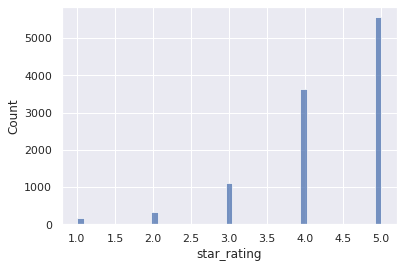

In [36]:
# libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
# df = sns.load_dataset("iris")
sns

sns.histplot(data=pd_vine_yes, x="star_rating")
plt.show()

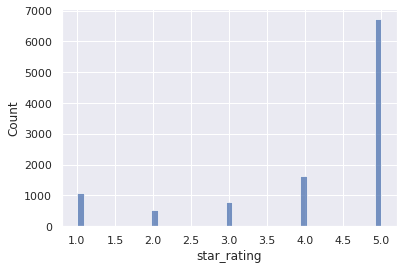

In [37]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
# df = sns.load_dataset("iris")
sns

sns.histplot(data=pd_vine_no, x="star_rating")
plt.show()

In a similar vein to the Kitchen Reviews dataset, non-Vine reviews seem to be more likely to assign either a 1-star or a 5-star review, whereas Vine reviews are slightly more evenly distributed.

In [38]:
import pandas as pd
vine_yes_no = pd.concat([pd_vine_yes, pd_vine_no])
vine_yes_no.head()

,star_rating,helpful_votes,total_votes,vine
review_id,,,,
R3OPBTY9W51JZA,4,0,0,Y
R35ZWBL9SCZ5B9,4,0,0,Y
R22Q1O3UQ2CODT,5,0,0,Y
R13CEN8DF0BCCO,3,0,0,Y
R2HDCTSKYX3R12,5,0,1,Y


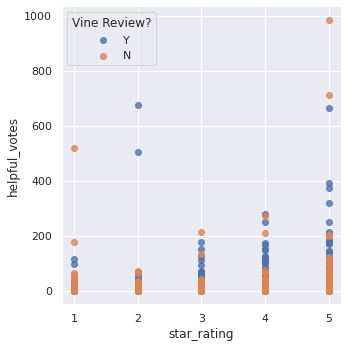

In [39]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="star_rating", y="helpful_votes", data=vine_yes_no, fit_reg=False, hue='vine', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper left', title='Vine Review?')

plt.show()

Just like in the Kitchen dataset, Vine reviews tend to be rated as more helpful.

In [40]:
review_date_df = homeimp_df.select(['review_id','review_date']).toPandas()
review_date_df.head()

,review_id,review_date
0,R215C9BDXTDQOW,2015-08-31
1,R1DTPUV1J57YHA,2015-08-31
2,RFAZK5EWKJWOU,2015-08-31
3,R2XT8X0O0WS1AL,2015-08-31
4,R14GRNANKO2Y2J,2015-08-31


In [41]:
vine_date_df = pd.merge(vine_yes_no, review_date_df, on='review_id', how='left')
vine_date_df.head()

,review_id,star_rating,helpful_votes,total_votes,vine,review_date
0,R3OPBTY9W51JZA,4,0,0,Y,2015-08-31
1,R35ZWBL9SCZ5B9,4,0,0,Y,2015-08-31
2,R22Q1O3UQ2CODT,5,0,0,Y,2015-08-31
3,R13CEN8DF0BCCO,3,0,0,Y,2015-08-31
4,R2HDCTSKYX3R12,5,0,1,Y,2015-08-31


In [54]:
vine_date_df

,review_id,star_rating,helpful_votes,total_votes,vine,review_date
10,R29V4UDSS053D8,3,33,38,Y,2015-08-30
84,R1I2D068WC37PA,3,32,37,Y,2015-08-19
87,R1L8Q6RTEJCYCG,4,13,13,Y,2015-08-19
160,R38ZHNTFVALA38,5,10,11,Y,2015-08-10
165,R3QOSWN265ZOKE,3,7,11,Y,2015-08-10
...,...,...,...,...,...,...
21521,RT6BXMXYY83GG,4,9,12,N,2005-10-08
21522,R2FRJUKMXAH1P2,1,22,23,N,2005-09-18
21529,R4BVUUPDGYBAT,2,8,20,N,2004-05-03
21531,R3RZM4BJHDQYIG,1,9,18,N,2003-12-13
